# Pryngles module: System

In [1]:
from pryngles import *

## External modules

In [2]:
import rebound as rb

## System Class

This is the most important class in the whole package.  This class allows to create the planetary system and manipulate it.

In [3]:
"""
#Create a simple system
#Once you create a system, a null spangler is created 

sys.set_observer(n_obs=[1,1,0],alpha_obs=0)

#Add star (by default, m = 1)
S=sys.add()

#Add planet, when an object is added, it is automatically spangled
P=sys.add("Planet",radius=0.1,m=1e-3,a=1,e=0.2)

#Add moon: orbital elements are respect to equatorial plane of the primary
M=sys.add("Planet",primary=P,radius=0.01,m=1e-7,a=0.1,e=0.01)

#Add ring system
R=sys.add("Ring",primary=P,fi=1.5,fe=2.5,albedo_gray_normal=0.5,tau_gray_optical=3)

#If you change the number of spangles of an object the spanglers are reset
sys.update_body(R,nspangles=800)

#Each time an object is updated, the spangler should be rejoined and the simulation reset.

#Spangle 
#sys.spangle_system()

#You may check separately the properties of each object
R.spangler.plot3d()
R.spangler.plot_obs()

#Plot
sys.spangler.plot3d()
sys.spangler.plot_obs()
""";

In [4]:
System_doc=\
f"""
Creates a planetary system.

Initialization attributes:

    units: list of strings, default = ['au','msun','yr']:
        Units used in calculations following the conventions and signs of rebound.
        The order SHOULD always be MKS: length, mass, time (in that order)

Derived attributes:

    sim: Simulation:
        REBOUND Simulation object.
        
    ul, um, ut: float [SI units]
        Value of the conversion factors for each unit.
        
    G: float [ul^3/ut^2/um]
        Value of the gravitational constant.

    hashes: list:
        List of hashes of bodies in the system.
        
    stars, planets, rings: lists:
        List of the corresponding kind of object in the system.
        
    nstars, nplanets, nrings, nobservers, nbodies: int
        Number of each kind of body in the system and of all bodies in the system.

Examples:

    #Create a system
    sys=System(units=["au","msun","yr"])
    sys.sim.integrator='wahfast'
    sys.sim.dt=0.01
    
    #Add star (by default, m = 1)
    S=sys.add()

    #Add planet, when an object is added, it is automatically spangled
    P=sys.add("Planet",radius=0.1,m=1e-3,a=1,e=0.2)

    #Add moon: orbital elements are respect to equatorial plane of the primary
    M=sys.add("Planet",primary=P,radius=0.01,m=1e-7,a=0.1,e=0.01)

    #Add ring system
    R=sys.add("Ring",primary=P,fi=1.5,fe=2.5,albedo_gray_normal=0.5,tau_gray_optical=3)

""";

In [5]:
class System(PrynglesCommon):
    
    def __init__(self,
                 units=['au','msun','yr'],
                ):
        
        #Rebound simulation
        self.sim=rb.Simulation()
        
        #Update rebound units
        self.update_units(units)
        
        #Bodies
        self.bodies=dict()
        self.nbodies=0
        
        #Update system
        self._update_system()
        
    def update_units(self,units):
        """Update units of the system
        """
        self.units=units
        
        #Units
        self._ul,self._um,self._ut=self.units
        self.sim.units=self.units
        
        #Canonical units of the system
        self.ul=rb.units.convert_length(1,self._ul,"m")
        self.um=rb.units.convert_mass(1,self._um,"kg")
        self.ut=np.sqrt(self.sim.G*self.ul**3/(self.um*GSI))
        
    def _update_system(self):
        """Update system properties
        """
        self.nbodies=len(self.bodies)
        self.nparticles=len(self.sim.particles)

System.__doc__=System_doc

In [6]:
if IN_JUPYTER:
    def test_system_init(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        sys=System()
        print(sys.nbodies)
        print(sys.sim.G)
        print(sys.ul,sys.um,sys.ut)
        
        sys=System(units=['m','kg','s'])
        print(sys.nbodies)
        print(sys.sim.G)
        print(sys.ul,sys.um,sys.ut)
        
        print(sys)

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_system_init=test_system_init
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.

0
39.476926421373
149597870700.0 1.9884754159665356e+30 31557600.0
0
6.67408e-11
1.0 1.0 1.0
{'sim': <rebound.simulation.Simulation object at 0x7fee223c0d40, N=0, t=0.0>, 'units': ['m', 'kg', 's'], 'ul': 1.0, 'um': 1.0, 'ut': 1.0, 'bodies': {}, 'nbodies': 0, 'nparticles': 0}



----------------------------------------------------------------------
Ran 1 test in 0.005s

OK


In [7]:
def add(self,kind="Star",primary=None,center="primary",**props):
    """Add an object to the system
    
    Examples:
    
        sys=System()
        S=sys.add("Star",m=2)
    
    Parameters:
    
        kind: string, default = "Star":
            Kind of object: Star, Planet, Ring (see BODY_KINDS).
    
        primary: Body, default = None:
            Primary object of the body.
            
        center: string, default = "primary":
            Center with respect to the positions are indicated.  
            Possible values: "primary", "inertial".
            When "inertial" you can provide positions of the objects using cartesian
            coordinates.

        props: dictionary:
            List of properties of the body.
            
    Returns:
        
        Body
            Body added to the system.
    """
    if kind is None:
        raise AssertionError("You must provide a valid object kind (Star, Planet, Ring).")

    if kind not in BODY_KINDS:
        raise ValueError(f"Object kind '{kind}' is not recognized.")

    exec(f"self.__body={kind}(primary=primary,**props)")
    self.bodies[self.__body.hash]=self.__body
    self.nbodies=len(self.bodies)
    
    if kind != "Ring":
        #Add body to simulation
        rb_add_options={k:v for k,v in self.__body.__dict__.items() if k in REBOUND_ORBITAL_PROPERTIES}
        rb_add_options.update(hash=self.__body.hash)
        
        if primary and center=="primary":
            rb_add_options.update(primary=self.sim.particles[primary.hash])

        verbose(VERB_VERIFY,f"Adding rebound object with hash {self.__body.hash} with center {center}")
        verbose(VERB_DEEP,f"Rebound add options {rb_add_options}")
        
        self.sim.add(**rb_add_options)
        self.__body.particle=self.sim.particles[self.__body.hash]
    else:
        self.__body.particle=self.sim.particles[self.__body.primary.hash]
    
    self._update_system()
    return self.__body
    
System.add=add

In [8]:
if IN_JUPYTER:
    def test_system_add(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        sys=System()
        S=sys.add(m=8,radius=4,x=5,vy=2)
        P=sys.add("Planet",primary=S,a=2,radius=2)
        M=sys.add("Planet",primary=P,a=2,radius=2)
        R=sys.add("Ring",primary=P,fi=1.3,fe=2.3)
        for particle in sys.sim.particles:
            print(particle)
            
        print(sys)

        Verbose.VERBOSITY=VERB_NONE
                
    class Test(unittest.TestCase):pass    
    Test.test_system_add=test_system_add
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_star_properties:: Updating properties of Star
      VERB3::limb_darkening:: Normalization of limb darkening function for cs = [], N = 3.141592653589793
      VERB3::add:: Adding rebound object with hash 8791279750446 with center primary
        VERB4::add:: Rebound add options {'m': 8, 'x': 5, 'vy': 2, 'hash': '8791279750446'}
      VERB3::_update_childs:: Add child 8791279750599 to body Star (8791279750446)
      VERB3::_update_primary:: Add primary 8791279750446 to body Planet (8791279750599)
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::update_planet:: Updating Planet
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_planet_properties:: Updating Planet properties
      VERB3::add:: Adding rebound object with hash 879127

.

      VERB3::_update_childs:: Add child 8791279750602 to body Planet (8791279750599)
      VERB3::_update_primary:: Add primary 8791279750599 to body Ring (8791279750602)
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::update_ring:: Updating Ring
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_ring_properties:: Updating Ring properties
<rebound.particle.Particle object at 0x7fee11c1a940, m=8.0 x=5.0 y=0.0 z=0.0 vx=0.0 vy=2.0 vz=0.0>
<rebound.particle.Particle object at 0x7fee11c1c6c0, m=1.0 x=7.0 y=0.0 z=0.0 vx=0.0 vy=15.32839708652839 vz=0.0>
<rebound.particle.Particle object at 0x7fee11c1a940, m=1.0 x=9.0 y=0.0 z=0.0 vx=0.0 vy=21.61146372801589 vz=0.0>
{'sim': <rebound.simulation.Simulation object at 0x7fee11b5a340, N=3, t=0.0>, 'units': ['au', 'msun', 'yr'], 'ul': 149597870700.0, 'um': 1.9884754159665356e+30, 'ut': 31557600.0, 'bodies': {'87


----------------------------------------------------------------------
Ran 1 test in 0.414s

OK


In [9]:
def remove(self,hash):
    """Remove a body from a system.

    Parameters:
        body_hash: string
            Hash of the body to remove
    
    Notes: 
        Remove eliminate body and all the childs and the childs of the childs.

    Example:
        sys=System()
        S=sys.add(m=2)
        sys.remove(hash=S.hash)
    """
    
    if hash in self.bodies:
        verbose(VERB_SIMPLE,f"Removing object {hash} from system")

        obj=self.bodies[hash]

        #Get the list of child hashes before removing (it changes during for)
        child_hashes=list(obj.childs.keys())
        
        #Remove child objects
        for child_hash in child_hashes:
            if child_hash in self.bodies:
                self.remove(child_hash)
                
        #Remove object from simulation
        if obj.kind != "Ring":
            verbose(VERB_SIMPLE,f"Removing particle {hash} from simulation")
            self.sim.remove(hash=hash)
        
        #Remove object from childs of its primary
        if obj.primary:
            del obj.primary.childs[hash]
        
        #Remove object from bodies
        del self.bodies[hash]

        #Update system
        self._update_system()
    else:
        raise ValueError("No object with hash 'body_hash' in the system")
System.remove=remove

In [10]:
if IN_JUPYTER:
    def test_system_remove(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        sys=System()
        S=sys.add(hash="Star",m=8,radius=4,x=5,vy=2)
        P=sys.add("Planet",primary=S,hash="Planet",a=2,radius=2)
        M=sys.add("Planet",primary=P,hash="Moon",a=2,radius=2)
        R=sys.add("Ring",primary=P,hash="Ring",fi=1.3,fe=2.3)
        print(sys.bodies)
        sys.remove("Ring")
        print(sys.bodies)
        sys.remove("Planet")
        print(sys.bodies)
        sys.remove("Star")
        print(sys.bodies)

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_system_remove=test_system_remove
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_star_properties:: Updating properties of Star
      VERB3::add:: Adding rebound object with hash Star with center primary
        VERB4::add:: Rebound add options {'m': 8, 'x': 5, 'vy': 2, 'hash': 'Star'}
      VERB3::_update_childs:: Add child Planet to body Star (Star)
      VERB3::_update_primary:: Add primary Star to body Planet (Planet)
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::update_planet:: Updating Planet
      VERB3::update_body:: Updating Body
      VERB3::_update_properties:: Updating properties of Body
      VERB3::_update_planet_properties:: Updating Planet properties
      VERB3::add:: Adding rebound object with hash Planet with center primary
        VERB4::add:: Rebound add options {'m': 1, 'a': 2, 'hash': 'Planet', 'primary': <rebound.particle.Particle object at 0x7fee11c1c

/Users/jorgezuluagacallejas/opt/anaconda3/lib/python3.9/site-packages/rebound/simulation.py:712: RuntimeWarning: Last particle removed.
  warnings.warn(msg[1:], RuntimeWarning)
.

  VERB1::remove:: Removing particle Planet from simulation
{'Star': <pryngles.body.Star object at 0x7fee2270f310>}
  VERB1::remove:: Removing object Star from system
  VERB1::remove:: Removing particle Star from simulation
{}



----------------------------------------------------------------------
Ran 1 test in 0.328s

OK


In [51]:
def spangle_system(self,n_obs=[0,0,1],alpha_obs=0,n_luz=[0,0,1]):
    
    self.spanglers=[]
    for hash,body in self.bodies.items():
        verbose(VERB_SIMPLE,f"Spangling body '{hash}' (kind '{body.kind}')")
        body.spangle_body()
        body.sp.set_positions(center_ecl=body.particle.xyz)
        self.spanglers+=[body.sp]
    
    #Join spanglers
    self.sp=Spangler(spanglers=self.spanglers)
    
    #Set observer
    self.sp.set_observer(n_obs=n_obs,alpha_obs=alpha_obs)

    #Set light-source
    self.sp.set_luz(n_luz=n_luz)
        
System.spangle_system=spangle_system

Spangling body 'Star' (kind 'Star')
Spangling body 'Planet' (kind 'Planet')
Spangling body 'Moon' (kind 'Planet')
Spangling body 'Ring' (kind 'Ring')


<IPython.core.display.Javascript object>


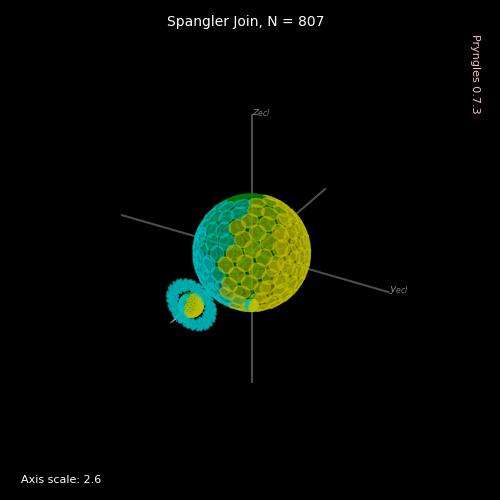

.
----------------------------------------------------------------------
Ran 1 test in 0.693s

OK


In [49]:
if IN_JUPYTER:
    def test_spangle(self):
        
        Verbose.VERBOSITY=VERB_NONE
        
        nspangles=200
        sys=System()
        S=sys.add(hash="Star",nspangles=nspangles,m=8,radius=1,x=0,vy=2)
        P=sys.add("Planet",primary=S,hash="Planet",nspangles=nspangles,radius=0.2,a=2)
        M=sys.add("Planet",primary=P,hash="Moon",nspangles=nspangles,radius=0.1,a=1,M=120*Consts.deg)
        R=sys.add("Ring",primary=P,hash="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=90*Consts.deg)
        sys.spangle_system(n_obs=[1,0,0],n_luz=[0,1,0])
        
        sys.sp.plot3d()

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass    
    Test.test_spangle=test_spangle
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

--End--

In [52]:
nspangles=200
sys=System()
S=sys.add(hash="Star",nspangles=nspangles,m=8,radius=1,x=0,vy=2)
P=sys.add("Planet",primary=S,hash="Planet",nspangles=nspangles,radius=0.2,a=2)
M=sys.add("Planet",primary=P,hash="Moon",nspangles=nspangles,radius=0.1,a=1,M=120*Consts.deg)
R=sys.add("Ring",primary=P,hash="Ring",nspangles=nspangles,fi=1.3,fe=2.3,i=90*Consts.deg)
sys.spangle_system(n_obs=[1,0,0],n_luz=[0,1,0])

In [55]:
%timeit -n 5 sys.spangle_system(n_obs=[1,0,0],n_luz=[0,1,0])

287 ms ± 3.44 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [46]:
len(sys.sp.data)

807

In [31]:
print_df(sys.sp.data)

,body_hash,type,dim,scale,center_ecl,x_ecl,y_ecl,z_ecl,r_ecl,q_ecl,f_ecl,ns_ecl,x_obs,y_obs,z_obs,r_obs,q_obs,f_obs,ns_obs,x_luz,y_luz,z_luz,r_luz,q_luz,f_luz,ns_luz,n_equ,alpha_equ,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,w,t0,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult,emit,hidden
0,Star,3,3,1.00,"[0.0, 0.0, 0.0]",-0.055400,-0.083101,-0.995000,1.000000,4.124394,-1.470755,"[-0.05539996671485913, -0.08310140605304141, -0.9950000000000001]",-0.083101,-0.995000,-0.055400,1.000000,4.629063,-0.055428,"[-0.08310140605304141, -0.9950000000000001, -0.05539996671485913]",-0.055400,-0.083101,-0.995000,1.000000,4.124394,-1.470755,"[-0.05539996671485913, -0.08310140605304141, -0.9950000000000001]","[6.123233995736766e-17, 0.0, 1.0]",0,"[0, 0, 0]",-0.083101,0.055400,-0.9950,1.000000,2.553598,-1.470755,"[-0.08310140605304141, 0.05539996671485907, -0.9950000000000001]",0,0,0.063148,0.283552,1,0.0,0,0,0,0,0,0,0,0,0
1,Star,3,3,1.00,"[0.0, 0.0, 0.0]",0.167560,0.041213,-0.985000,1.000000,0.241172,-1.397374,"[0.16756037997528125, 0.041213093338638804, -0.9850000000000001]",0.041213,-0.985000,0.167560,1.000000,4.754205,0.168355,"[0.041213093338638804, -0.9850000000000001, 0.16756037997528125]",0.167560,0.041213,-0.985000,1.000000,0.241172,-1.397374,"[0.16756037997528125, 0.041213093338638804, -0.9850000000000001]","[6.123233995736766e-17, 0.0, 1.0]",0,"[0, 0, 0]",0.041213,-0.167560,-0.9850,1.000000,4.953561,-1.397374,"[0.041213093338638804, -0.1675603799752813, -0.9850000000000001]",0,0,0.063148,0.283552,1,0.0,0,1,0,0,0,0,0,0,0
2,Star,3,3,1.00,"[0.0, 0.0, 0.0]",-0.194954,0.106620,-0.975000,1.000000,2.641136,-1.346721,"[-0.19495440174377593, 0.10661979760216439, -0.9750000000000001]",0.106620,-0.975000,-0.194954,1.000000,4.821310,-0.196211,"[0.10661979760216439, -0.9750000000000001, -0.19495440174377593]",-0.194954,0.106620,-0.975000,1.000000,2.641136,-1.346721,"[-0.19495440174377593, 0.10661979760216439, -0.9750000000000001]","[6.123233995736766e-17, 0.0, 1.0]",0,"[0, 0, 0]",0.106620,0.194954,-0.9750,1.000000,1.070339,-1.346721,"[0.10661979760216439, 0.19495440174377587, -0.9750000000000001]",0,0,0.063148,0.283552,1,0.0,0,0,0,0,0,0,0,0,0
3,Star,3,3,1.00,"[0.0, 0.0, 0.0]",0.084660,-0.248209,-0.965000,1.000000,5.041099,-1.305443,"[0.08466009308699192, -0.24820892135155398, -0.9650000000000001]",-0.248209,-0.965000,0.084660,1.000000,4.460635,0.084762,"[-0.24820892135155398, -0.9650000000000001, 0.08466009308699192]",0.084660,-0.248209,-0.965000,1.000000,5.041099,-1.305443,"[0.08466009308699192, -0.24820892135155398, -0.9650000000000001]","[6.123233995736766e-17, 0.0, 1.0]",0,"[0, 0, 0]",-0.248209,-0.084660,-0.9650,1.000000,3.470303,-1.305443,"[-0.24820892135155398, -0.08466009308699197, -0.9650000000000001]",0,0,0.063148,0.283552,1,0.0,0,1,0,0,0,0,0,0,0
4,Star,3,3,1.00,"[0.0, 0.0, 0.0]",0.119024,0.271677,-0.955000,1.000000,1.157877,-1.269660,"[0.11902352142399435, 0.2716770165984454, -0.955]",0.271677,-0.955000,0.119024,1.000000,4.989546,0.119306,"[0.2716770165984454, -0.955, 0.11902352142399435]",0.119024,0.271677,-0.955000,1.000000,1.157877,-1.269660,"[0.11902352142399435, 0.2716770165984454, -0.955]","[6.123233995736766e-17, 0.0, 1.0]",0,"[0, 0, 0]",0.271677,-0.119024,-0.9550,1.000000,5.870266,-1.269660,"[0.2716770165984454, -0.1190235214239944, -0.955]",0,0,0.063148,0.283552,1,0.0,0,1,0,0,0,0,0,0,0
5,Star,3,3,1.00,"[0.0, 0.0, 0.0]",-0.299143,-0.132245,-0.945000,1.000000,3.557840,-1.237595,"[-0.29914267398711597, -0.13224469970414005, -0.9450000000000001]",-0.132245,-0.945000,-0.299143,1.000000,4.573350,-0.303794,"[-0.13224469970414005, -0.9450000000000001, -0.29914267398711597]",-0.299143,-0.132245,-0.945000,1.000000,3.557840,-1.237595,"[-0.29914267398711597, -0.13224469970414005, -0.9450000000000001]","[6.123233995736766e-17, 0.0, 1.0]",0,"[0, 0, 0]",-0.132245,0.299143,-0.9450,1.000000,1.987044,-1.237595,"[-0.13224469970414005, 0.2991426739871159, -0.9450000000000001]",0,0,0.

<IPython.core.display.Javascript object>


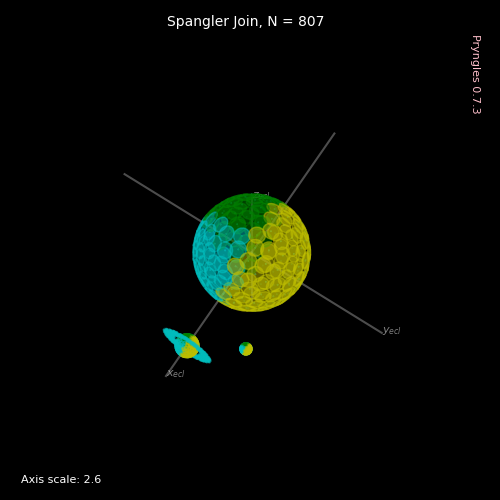

In [42]:
sys.sp.plot3d()

<IPython.core.display.Javascript object>


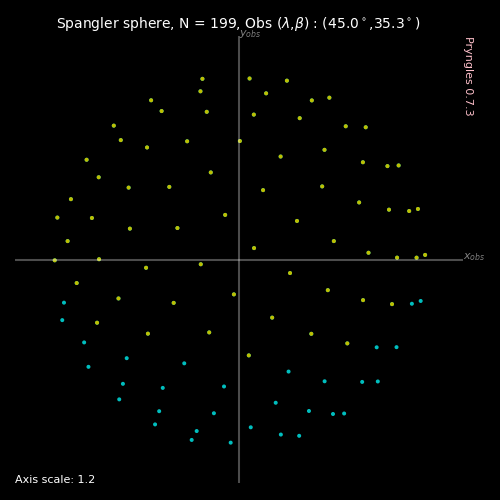

<IPython.core.display.Javascript object>


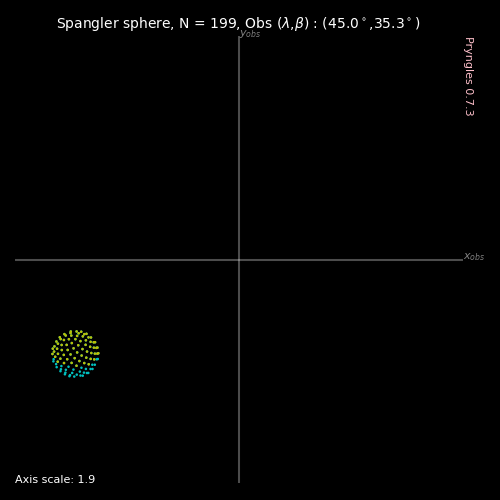

<IPython.core.display.Javascript object>


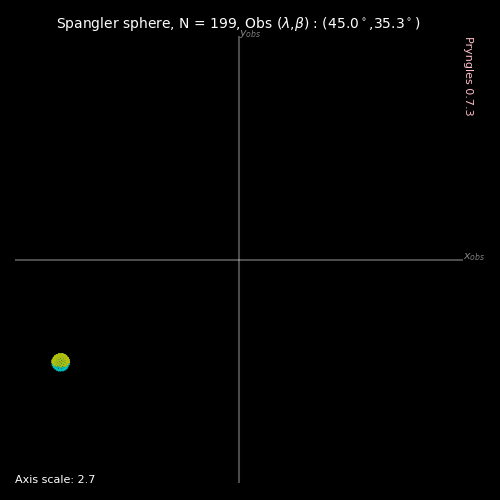

<IPython.core.display.Javascript object>


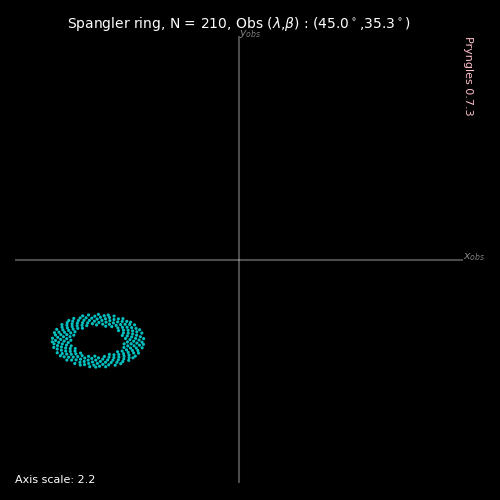

In [13]:
for sp in sys.spanglers:
    sp.plot_obs()

<IPython.core.display.Javascript object>


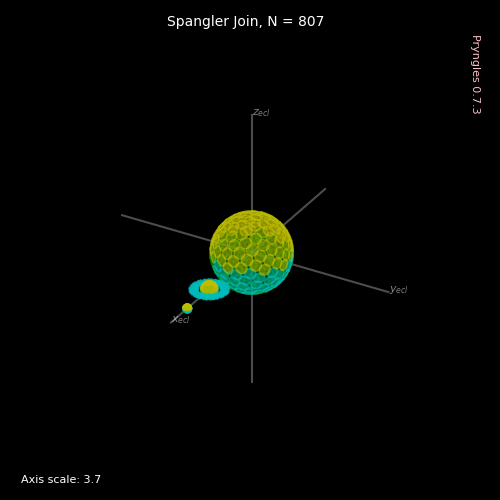

In [14]:
sys.sp.plot3d()

<IPython.core.display.Javascript object>


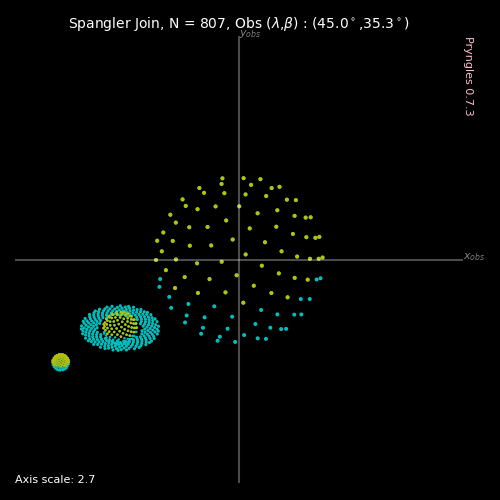

In [15]:
sys.sp.plot_obs()

In [18]:
#Create a simple system
sys=System(units=["au","msun","yr"])
sys.sim.integrator='whfast'
sys.sim.dt=0.01
#Once you create a system, a null spangler is created 
"""
You may set the observer from the very beginning
"""
sys.set_observer(n_obs=[1,1,0],alpha_obs=0)

#Add star (by default, m = 1)
S=sys.add()

#Add planet, when an object is added, it is automatically spangled
P=sys.add("Planet",radius=0.1,m=1e-3,a=1,e=0.2)

#Add moon: orbital elements are respect to equatorial plane of the primary
M=sys.add("Planet",primary=P,radius=0.01,m=1e-7,a=0.1,e=0.01)

#Add ring system
R=sys.add("Ring",primary=P,fi=1.5,fe=2.5,albedo_gray_normal=0.5,tau_gray_optical=3)

#If you change the number of spangles of an object the spanglers are reset
sys.update_body(R,nspangles=800)

#Each time an object is updated, the spangler should be rejoined and the simulation reset.

#Spangle 
#sys.spangle_system()

#You may check separately the properties of each object
R.spangler.plot3d()
R.spangler.plot_obs()

#Plot
sys.spangler.plot3d()
sys.spangler.plot_obs()

AttributeError: 'System' object has no attribute 'set_observer'

In [ ]:
print(R)

In [ ]:
#Update properties of objects, even after the system is spangled
sys.update_body(S,limb_coeffs=[0.5,0.2])
sys.update_body(R,i=30*Consts.deg,roll=60*Consts.deg)
sys.update_body(P,Prot=24*Const.hour/sys.ul)

In [ ]:
sys.set_observer(n_obs=[1,1,1],alpha_obs=0)

In [ ]:
#When you integrate you update the position of the bodies, recalculate light sources, observer configuration and 
sys.sim_integrate(0.5)

sys.spangler.plot3d()
sys.spangler.plot_obs()

In [ ]:
sys.sim_reset()

In [ ]:
#Update positions: in this way you can move the planet, for instance, around the star
sys.update_body(R,M=30*Consts.deg)

In [ ]:
"""
You may integrate without calculating photometry

Once you're ready calculate photometry
"""
sys.calc_photometry()

In [ ]:
"""
This routine only update the optical states of the spangles
"""
sys._update_states()

"""
This routine update temperatures.  This take into account the illumination history of the spangles
"""
sys._update_temperatures()